In [26]:
# Loading all needed packages at the start
import elastix 
import imageio.v2 as imageio
import matplotlib.pyplot as plt
import os
import SimpleITK as sitk
import numpy as np

## Fill in your own paths in the cell below ##

In [2]:
# to Elastix.exe
ELASTIX_PATH = 'C:/Users/20183303/Documents/Jaar 5 - ME/Q3/CS in medische beeldanalyse/Elastix files/Elastix.exe'
el = elastix.ElastixInterface(elastix_path=ELASTIX_PATH)
# to Transformix.exe
TRANSFORMIX_PATH = 'C:/Users/20183303/Documents/Jaar 5 - ME/Q3/CS in medische beeldanalyse/Elastix files/Transformix.exe'
# to TrainingData
filepath_data = r'C:\Users\20183303\Documents\Jaar 5 - ME\Q3\CS in medische beeldanalyse\Image Registration Assignment\TrainingData'


### Load patient data and inspect

In [13]:
def loadPatientDataReadable(patient_nr, filepath):
    """ 
    The MR images and masks are loaded for the specified patient in a 3D array.
    
    input:
    patient_nr: str - choose which patient data to load (e.g. 'p102', 'p107', 'p108', etc.)
    filepath: str - path leading to where your data is stored
    
    output:
    loaded_mr: 3D array - MR images loaded
    loaded_mask: 3D array - masks loaded
    
    """
    file_p_mr = filepath+ '\{}\mr_bffe.mhd'.format(patient_nr)  # example of patient 102 input MR image
    file_p_mask = filepath+'\{}\prostaat.mhd'.format(patient_nr) # example of patient 102 segmentation mask

    # Convert so images can be inspected
    loaded_mr = imageio.imread(file_p_mr)
    loaded_mask = imageio.imread(file_p_mask)
    
    return loaded_mr, loaded_mask

In [21]:
loaded_mr_107, loaded_mask_107 = loadPatientDataReadable('p102', filepath=filepath_data) 
loaded_mr_108, loaded_mask_108 = loadPatientDataReadable('p108', filepath=filepath_data)

In [106]:
# Visualize the slices you want to inspect, together with segmentation mask
def visualizeSlices(loaded_mr_array, loaded_mask_array, range_slices, patient_nr_plot):
    """
    The slices specified will be shown for the MRI image and mask that are loaded.
    
    input: 
    loaded_mr_array: 3D array - MR images loaded
    loaded_mask_array: 3D array - masks loaded
    range_slices: int - which slices to inspect, starting at slice 0 # Clean up 
    patient_nr_plot: int - which patient is visualized 
    
    output:
    -
    
    """
    for i in range(range_slices):
        fig, ax = plt.subplots(1, 2, figsize=(7, 5))
        ax[0].imshow(loaded_mr_array[i,:,:], cmap='gray')
        ax[0].set_title('MR input image, \nslice {}, {}'.format(i, patient_nr_plot))
        ax[1].imshow(loaded_mask_array[i,:,:], cmap='gray')
        ax[1].set_title('Segmentation mask, \nslice {}, {}'.format(i, patient_nr_plot))
        plt.show()

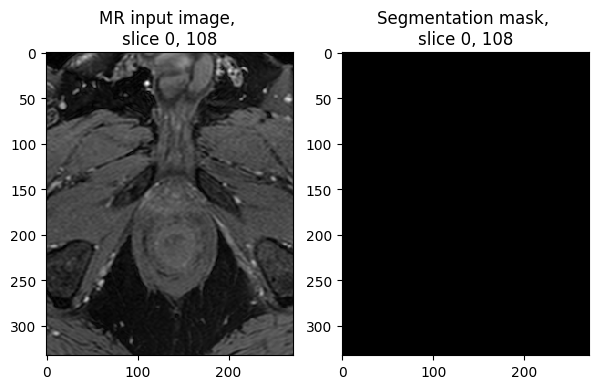

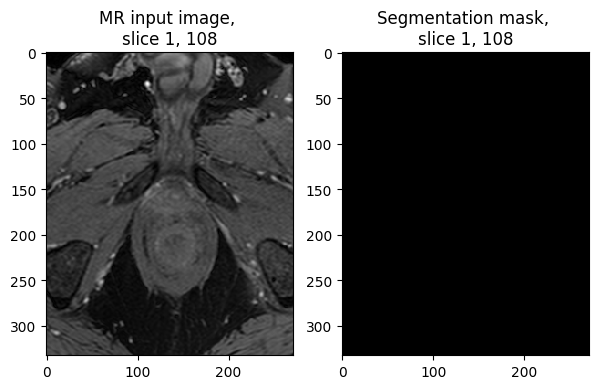

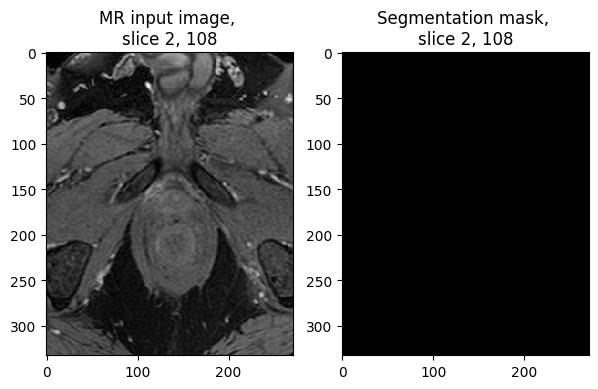

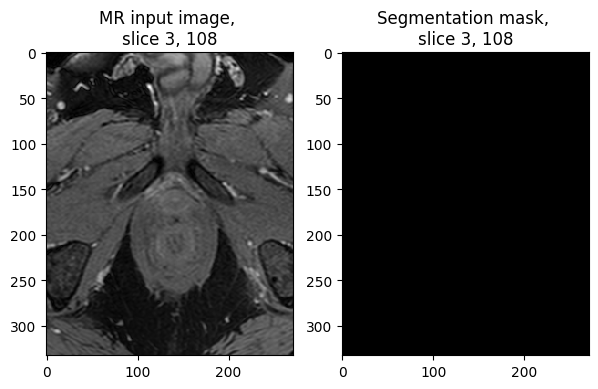

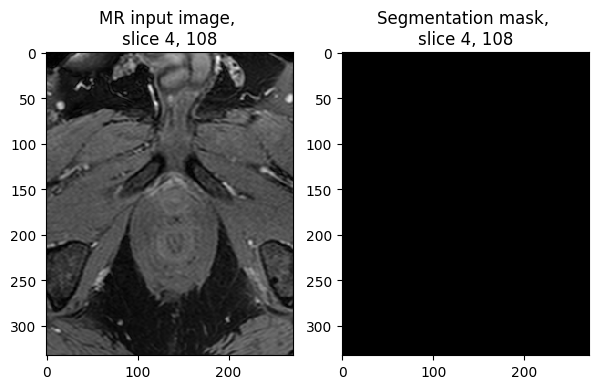

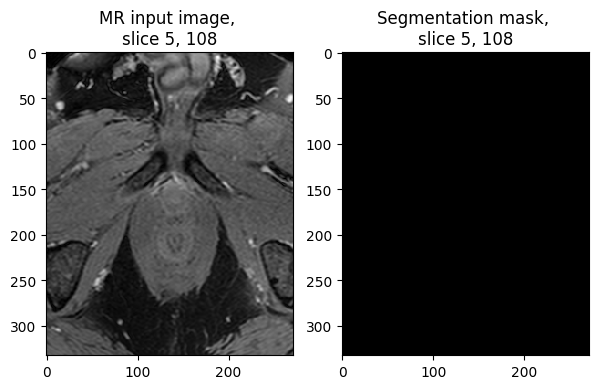

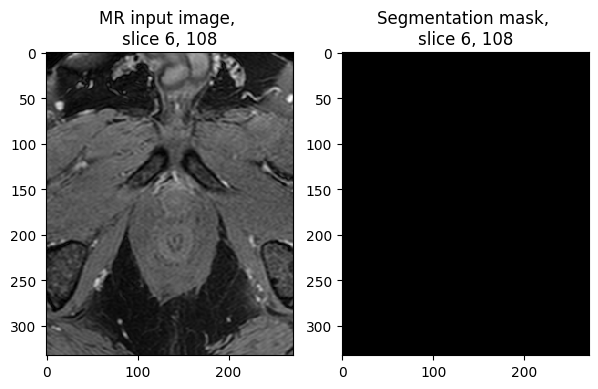

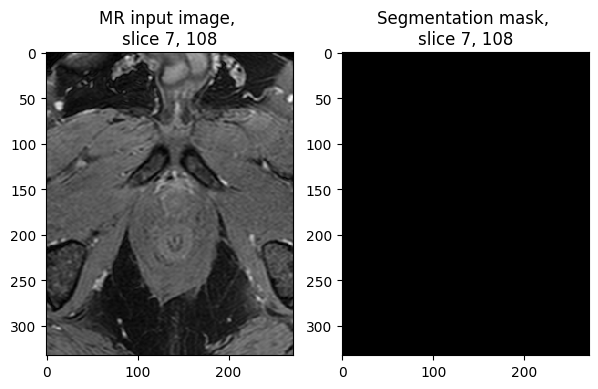

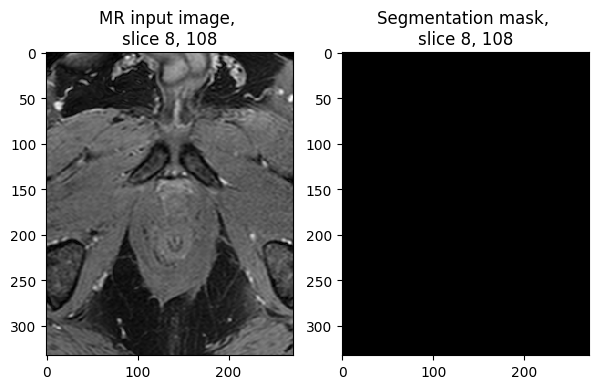

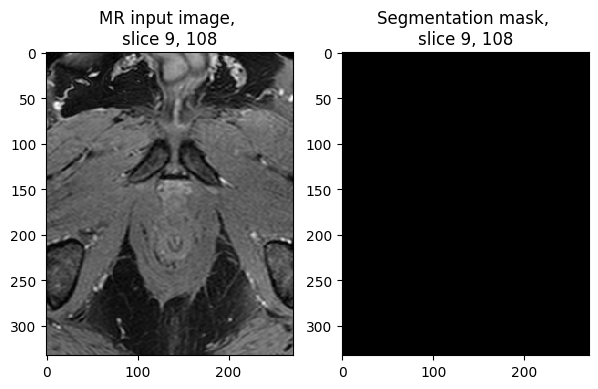

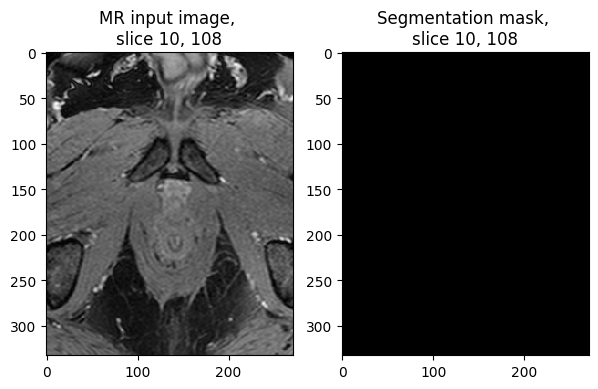

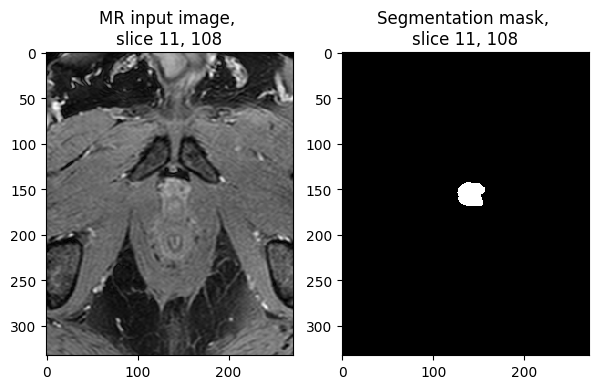

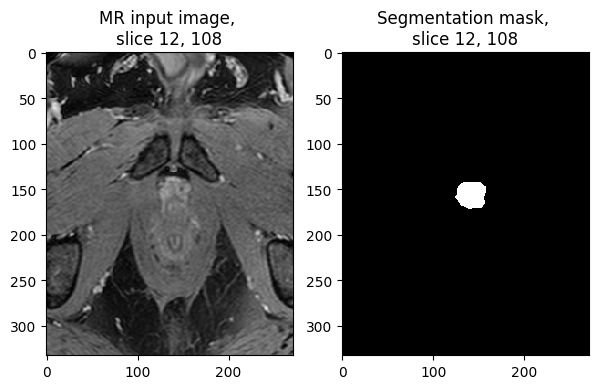

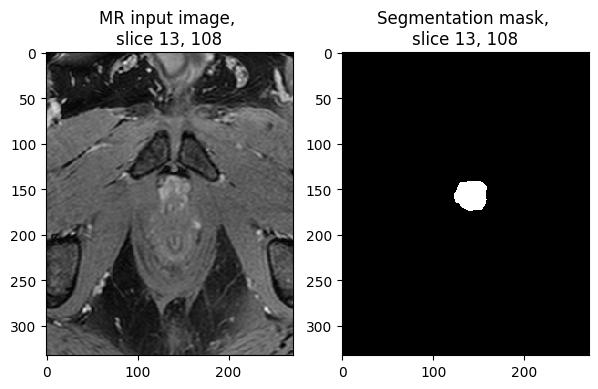

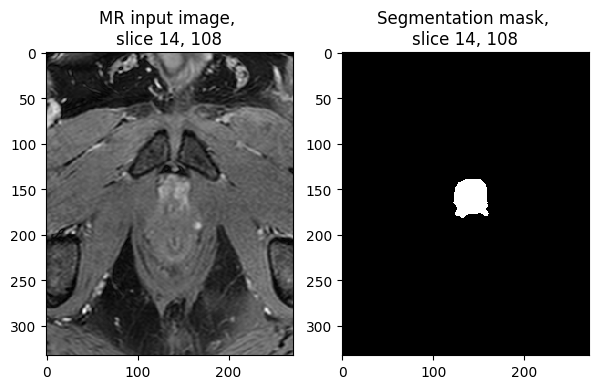

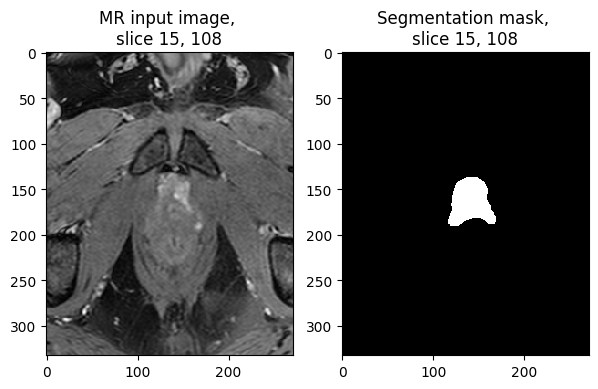

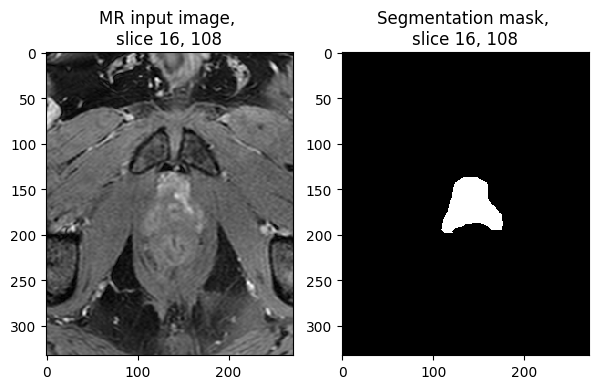

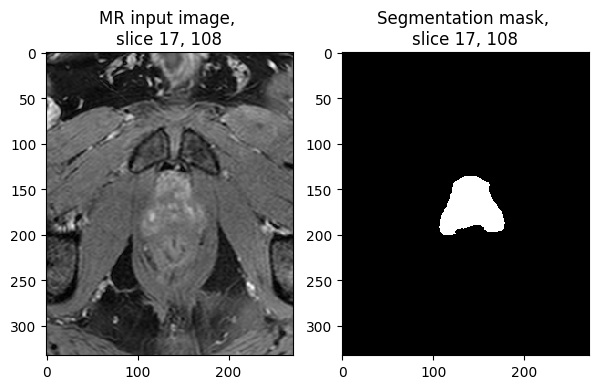

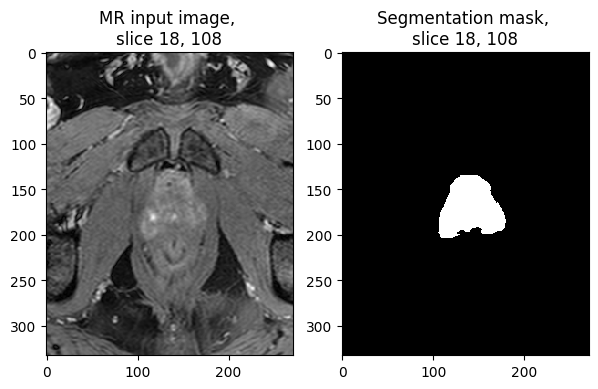

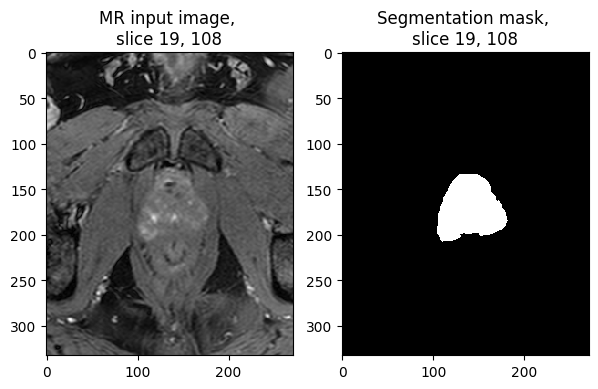

In [107]:
visualizeSlices(loaded_mr_108, loaded_mask_108, 20, 108)

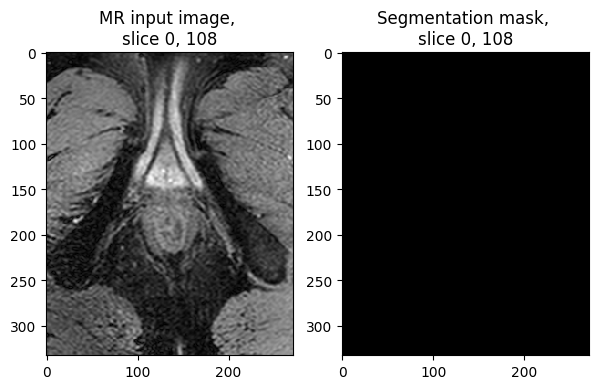

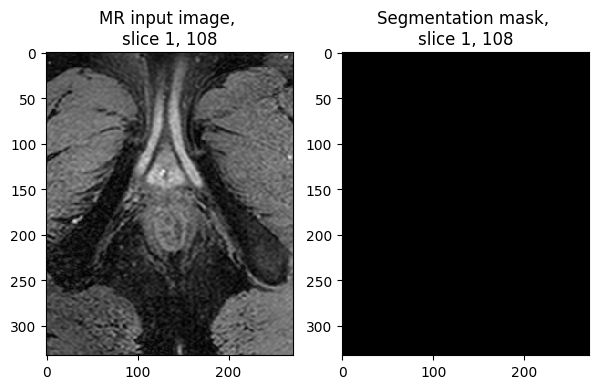

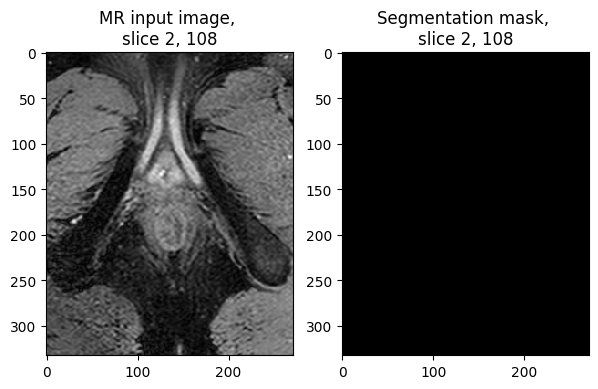

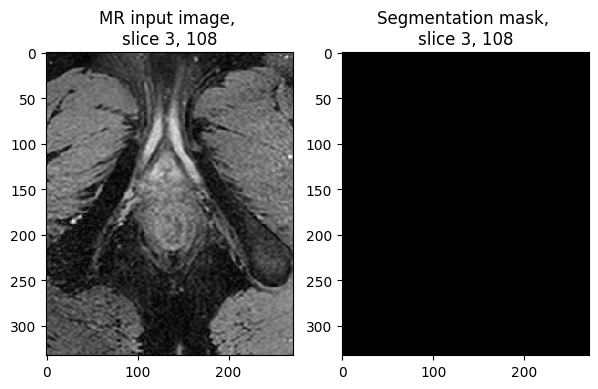

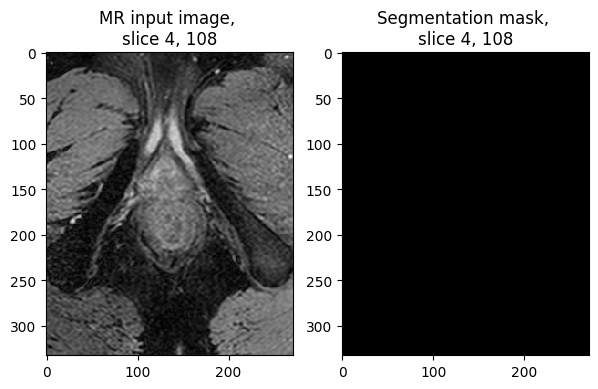

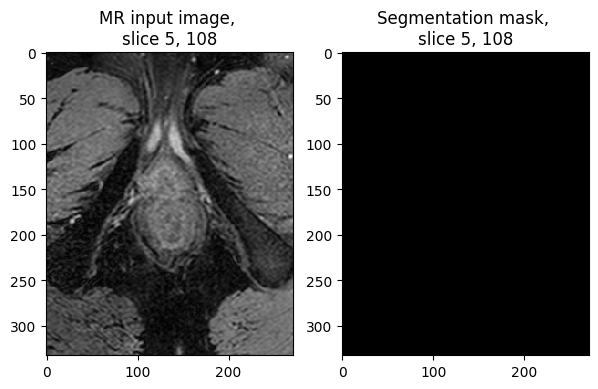

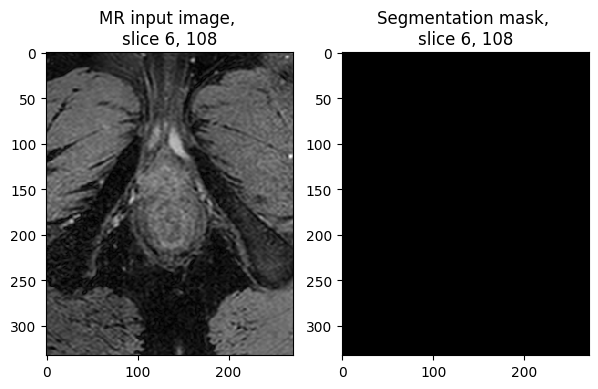

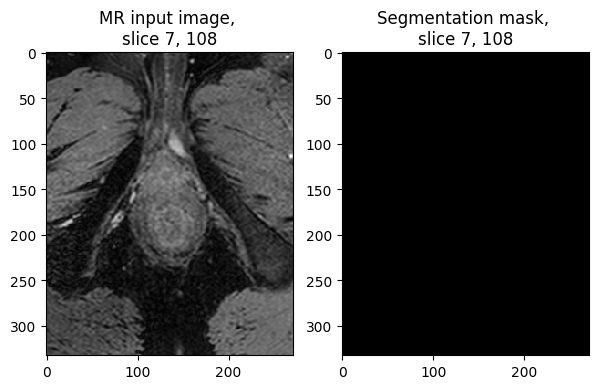

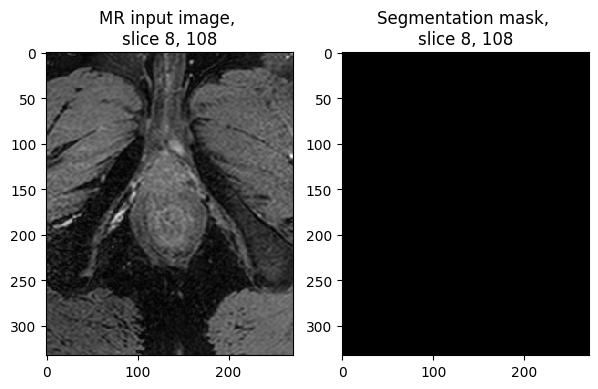

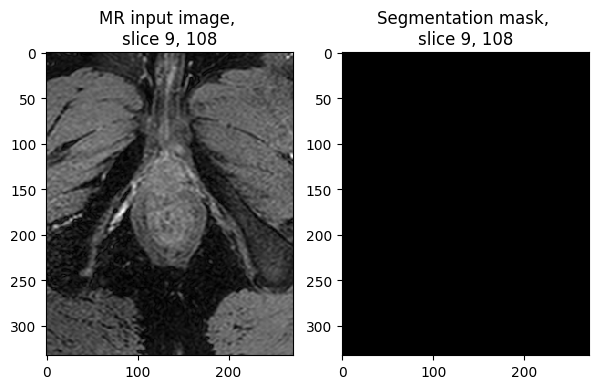

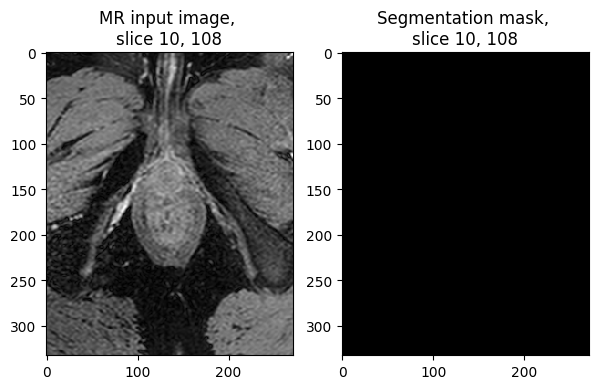

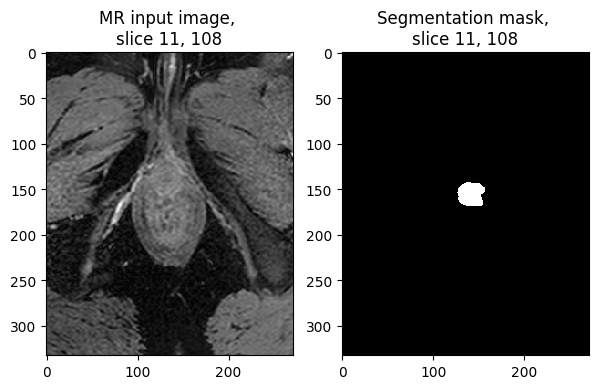

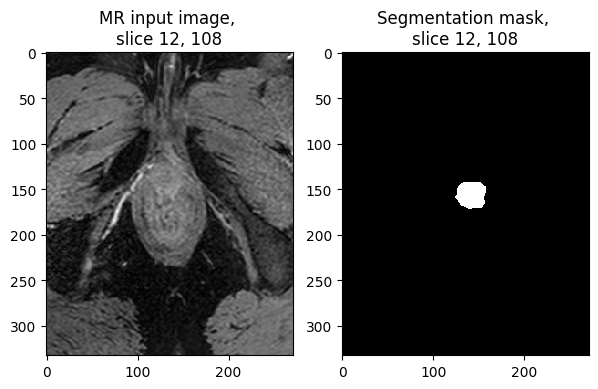

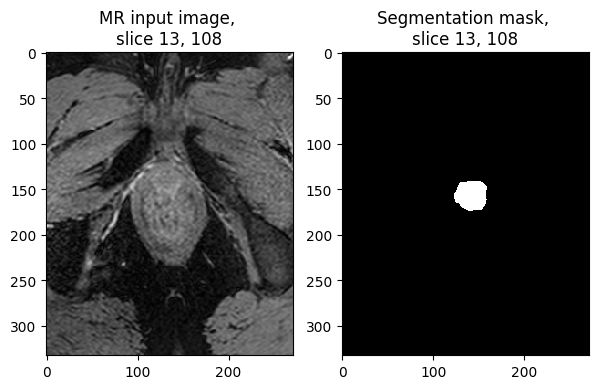

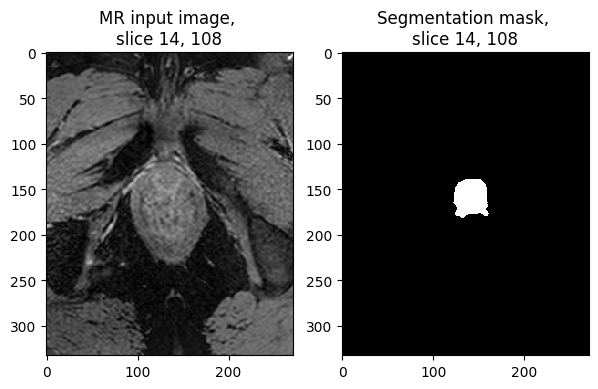

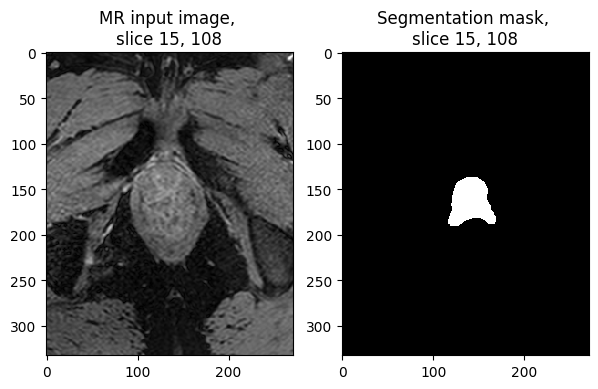

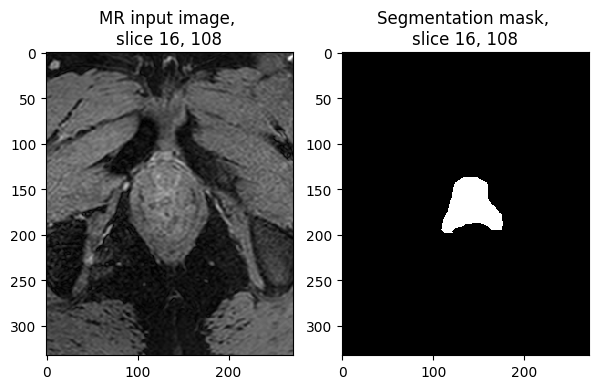

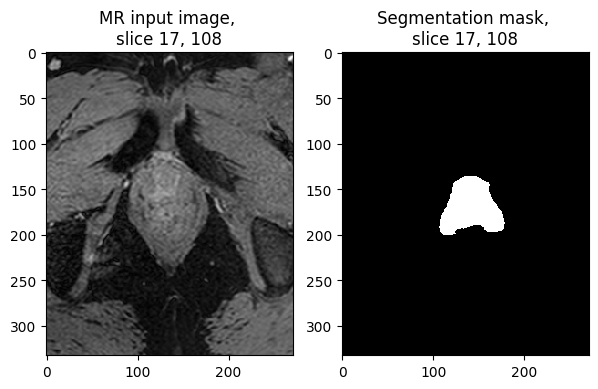

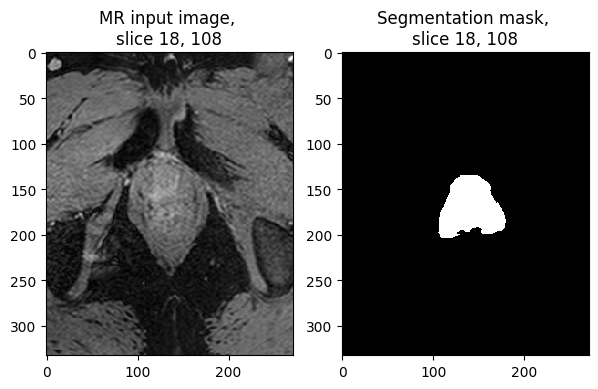

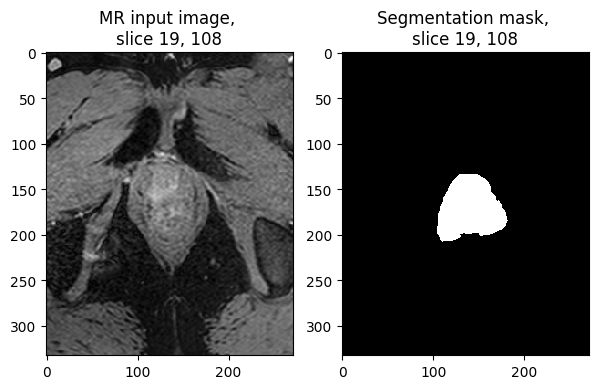

In [108]:
visualizeSlices(loaded_mr_107, loaded_mask_108, 20, 108)

### From here: calculate mutual information to find the 5 most similar slices


In [291]:
plt.rcParams['image.cmap'] = 'gray'
plt.rcParams['image.interpolation'] = 'nearest'

In [301]:
def mutualInformation(fixed_patient, moving_patient_slice, slice_nr_fixed):
    """ Mutual information for joint histogram
    """
    hgram, __, __ = np.histogram2d(fixed_patient[slice_nr_fixed,:,:].ravel(), moving_patient_slice.ravel(), bins=30)
    
    # Convert bins counts to probability values
    pxy = hgram / float(np.sum(hgram))
    px = np.sum(pxy, axis=1) # marginal for x over y
    py = np.sum(pxy, axis=0) # marginal for y over x
    px_py = px[:, None] * py[None, :] # Broadcast to multiply marginals
    # Now we can do the calculation using the pxy, px_py 2D arrays
    nzs = pxy > 0 # Only non-zero pxy values contribute to the sum
    return np.sum(pxy[nzs] * np.log(pxy[nzs] / px_py[nzs]))

##### Here we start trying to implement the retrieval of the most similar slices


In [161]:
# For now: select the patient slice that serves as fixed image
slice_nr = 85
#fixed_mr = loaded_mr_107[slice_nr,:,:]


In [228]:
# load all patient data in own arrays (3D)
patient_nrs_list = ['p102','p107', 'p108', 'p109', 'p115', 'p116', 'p117', 
                    'p119', 'p120', 'p125', 'p127','p128', 'p129', 'p133', 'p135']


In [305]:
def getTwentyNearest(slice_nr_fixed, loaded_patient_mr, fixed_mr):
    """
    Function (under construction) to obtain +9 to -9 (i.e., 19 in total) nearest slices for specified patient
    """
    
    # Create list of indexes (with nothing out of range)
    list_of_index = []
    for j in range(slice_nr_fixed-9, slice_nr_fixed+10):
        list_of_index.append(j)    
    list_index_processed = [item for item in list_of_index if item >= 0 and item < 86] # removes items <0 and >85

    # Perform MI computation part
    MI_calc=[]
    for slices_from_list in list_index_processed:
        MI_calc.append(mutualInformation(fixed_mr, loaded_patient_mr[slices_from_list,:,:], slice_nr_fixed))
    
    return MI_calc

In [308]:
MI_107 = getTwentyNearest(30, loaded_mr_107, loaded_mr_108)
print(len(MI_107))

[21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39]
[0.036866328317563396, 0.03856830841325548, 0.04013064878726538, 0.04350398453334292, 0.0446097982087537, 0.04825648368876698, 0.052435097801147884, 0.054102061238652924, 0.05547707247845526, 0.05550278512917026, 0.05591382325028503, 0.05729088151143176, 0.0574618952425086, 0.05593784964446074, 0.05598975091776287, 0.05797827125229263, 0.06048643598504116, 0.06121153584927909, 0.061558876222510606]
19


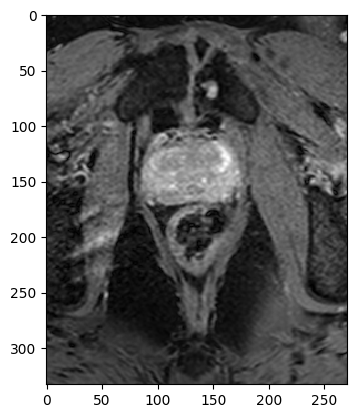

In [276]:
plt.imshow(list_slices_107[18])

In [ ]:
### ignore for now ###
    loaded_mr_107, __ = loadPatientDataReadable('p107', filepath=filepath_data)
    loaded_mr_108, __ = loadPatientDataReadable('p108', filepath=filepath_data)
    loaded_mr_109, __ = loadPatientDataReadable('p109', filepath=filepath_data)
    loaded_mr_115, __ = loadPatientDataReadable('p115', filepath=filepath_data)
    loaded_mr_116, __ = loadPatientDataReadable('p116', filepath=filepath_data)
    loaded_mr_117, __ = loadPatientDataReadable('p117', filepath=filepath_data)
    loaded_mr_119, __ = loadPatientDataReadable('p119', filepath=filepath_data)
    loaded_mr_120, __ = loadPatientDataReadable('p120', filepath=filepath_data)
    loaded_mr_125, __ = loadPatientDataReadable('p125', filepath=filepath_data)
    loaded_mr_127, __ = loadPatientDataReadable('p127', filepath=filepath_data)
    loaded_mr_128, __ = loadPatientDataReadable('p128', filepath=filepath_data)
    loaded_mr_129, __ = loadPatientDataReadable('p129', filepath=filepath_data)
    loaded_mr_133, __ = loadPatientDataReadable('p133', filepath=filepath_data)
    loaded_mr_135, __ = loadPatientDataReadable('p135', filepath=filepath_data)

In [6]:
## Try out some transformation with elastix, bspline multires parameters file

In [5]:
parameter_file_path_experiment = os.path.join(filepath_data,'parameters_bspline_multires_MR.txt')
output_file_path_experiment = os.path.join(filepath_data,'results')

fixed_image_path = filepath_data+'\p107\mr_bffe.mhd'
moving_image_path = filepath_data+'\p102\mr_bffe.mhd'

print(parameter_file_path_experiment)

C:\Users\20183303\Documents\Jaar 5 - ME\Q3\CS in medische beeldanalyse\Image Registration Assignment\TrainingData\parameters_bspline_multires_MR.txt


In [6]:
el.register(
    fixed_image=fixed_image_path,
    moving_image=moving_image_path,
    parameters=[parameter_file_path_experiment],
    output_dir=output_file_path_experiment)

C:/Users/20183303/Documents/Jaar 5 - ME/Q3/CS in medische beeldanalyse/Elastix files/Elastix.exe -f C:\Users\20183303\Documents\Jaar 5 - ME\Q3\CS in medische beeldanalyse\Image Registration Assignment\TrainingData\p107\mr_bffe.mhd -m C:\Users\20183303\Documents\Jaar 5 - ME\Q3\CS in medische beeldanalyse\Image Registration Assignment\TrainingData\p102\mr_bffe.mhd -p C:\Users\20183303\Documents\Jaar 5 - ME\Q3\CS in medische beeldanalyse\Image Registration Assignment\TrainingData\parameters_bspline_multires_MR.txt -out C:\Users\20183303\Documents\Jaar 5 - ME\Q3\CS in medische beeldanalyse\Image Registration Assignment\TrainingData\results


In [7]:
itk_image_fixed = sitk.ReadImage(fixed_image_path)
image_array_fixed = sitk.GetArrayFromImage(itk_image_fixed)
itk_image_moving = sitk.ReadImage(moving_image_path)
image_array_moving = sitk.GetArrayFromImage(itk_image_moving)

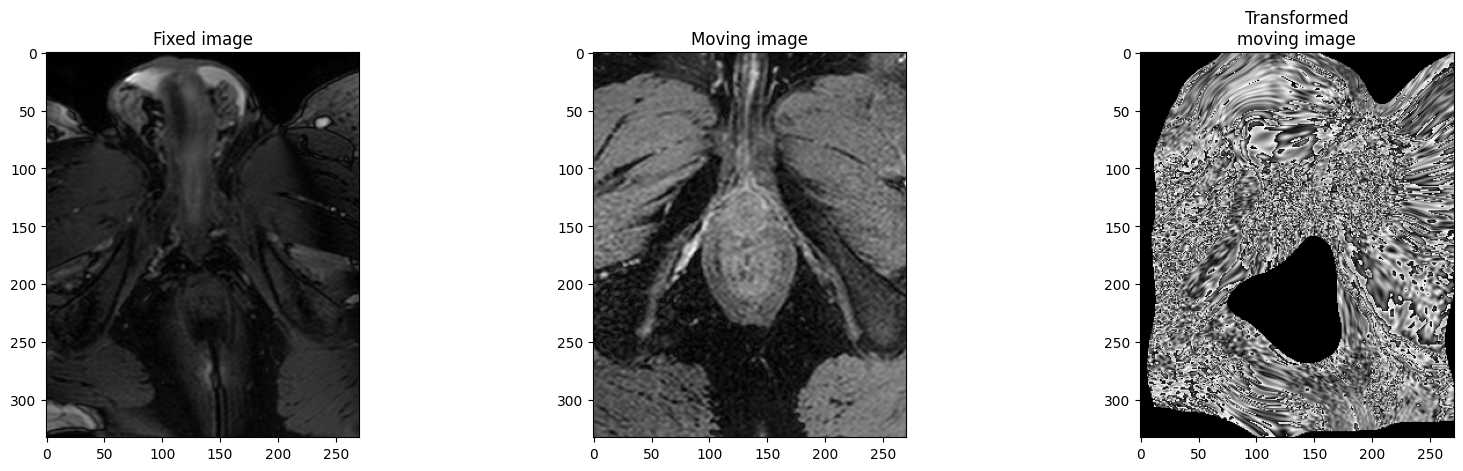

In [8]:
result_path_experiment = os.path.join(output_file_path_experiment, 'result.0.tiff')

transformed_moving_image = imageio.imread(result_path_experiment)

fig, ax = plt.subplots(1, 3, figsize=(20, 5))
ax[0].imshow(image_array_fixed[10,:,:], cmap='gray')
ax[0].set_title('Fixed image')
ax[1].imshow(image_array_moving[10,:,:], cmap='gray')
ax[1].set_title('Moving image')
ax[2].imshow(transformed_moving_image[10,:,:], cmap='gray')
ax[2].set_title('Transformed\nmoving image')

plt.show()